***SPAM MESSAGE DETECTION***

---



In [ ]:
!pip install nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Data preprocessing

Removing Stopwords

In [ ]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

#Load your dataset
df = pd.read_csv('/content/drive/MyDrive/codsoft/Spam message/spam.csv', encoding='latin1')

#Text cleaning
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ''.join([char for char in text if not char.isdigit()])
    return text

df['v2_cleaned'] = df['v2'].apply(clean_text)

#Tokenization
df['tokens'] = df['v2_cleaned'].apply(word_tokenize)

#Stopword Removal
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['tokens_no_stop'] = df['tokens'].apply(remove_stopwords)

#Stemming
stemmer = PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(word) for word in tokens]

df['stemmed_tokens'] = df['tokens_no_stop'].apply(stem_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Converting the data into TF-IDF matrix

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Convert the Stemmed Tokens Back to Text
def tokens_to_text(tokens):
    return ' '.join(tokens)

df['stemmed_text'] = df['stemmed_tokens'].apply(tokens_to_text)

#TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the stemmed text data to obtain the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['stemmed_text'])

#Convert TF-IDF Matrix to a DataFrame (Optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


# Training the model using SVM Classifier

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X contains the features (e.g., TF-IDF matrix) and y contains the labels ('v1' column)
X = tfidf_matrix
y = df['v1']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize the SVM classifier
clf = SVC(kernel='linear', C=1.0, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy on the validation set: {accuracy:.2f}")

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Accuracy on the validation set: 0.99

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       729
        spam       1.00      0.89      0.94       107

    accuracy                           0.99       836
   macro avg       0.99      0.94      0.97       836
weighted avg       0.99      0.99      0.99       836



In [ ]:
# Make predictions on the test set
y_test_pred = clf.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nAccuracy on the test set: {test_accuracy:.2f}")



Accuracy on the test set: 0.97


Accuracy is higher but the F1 score for both the classes is not equal..so checking the distribution of the classes

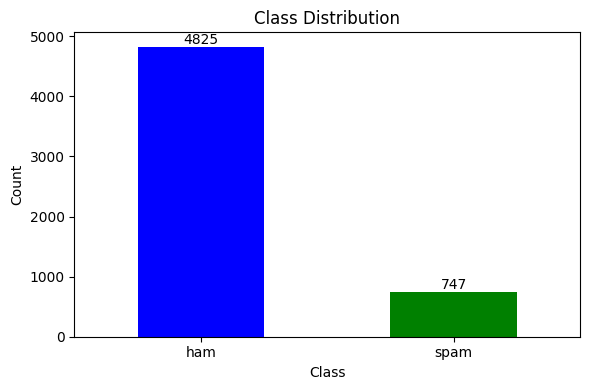

In [ ]:
import matplotlib.pyplot as plt

# Count the number of occurrences of each class
class_counts = df['v1'].value_counts()

# Plot the class distribution
plt.figure(figsize=(6, 4))
bars = class_counts.plot(kind='bar', color=['blue', 'green'])

# Annotate each bar with its count value
for i, count in enumerate(class_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Oversampling

Since the dataset is imbalanced..

In [ ]:
from imblearn.over_sampling import SMOTE

# Create the SMOTE object
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to oversample the minority class ('spam' in this case)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
y_resampled.value_counts()

ham     4825
spam    4825
Name: v1, dtype: int64

Yayy !! It is balanced

Training the SVM model with the balanced data

In [ ]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy on the validation set: {accuracy:.2f}")

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

Accuracy on the validation set: 1.00

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       704
        spam       1.00      0.99      1.00       743

    accuracy                           1.00      1447
   macro avg       1.00      1.00      1.00      1447
weighted avg       1.00      1.00      1.00      1447



In [ ]:
# Make predictions on the test set
y_test_pred = clf.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nAccuracy on the test set: {test_accuracy:.2f}")


Accuracy on the test set: 0.99


#Visualizing the classification report on the test data

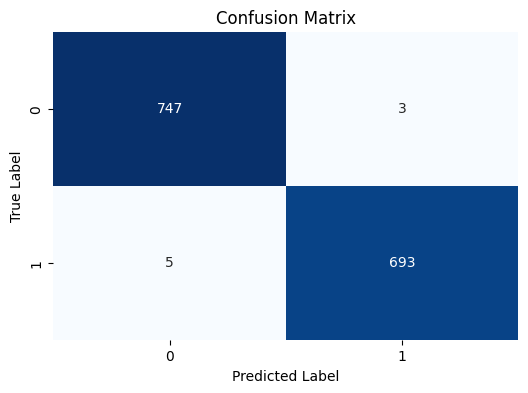

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

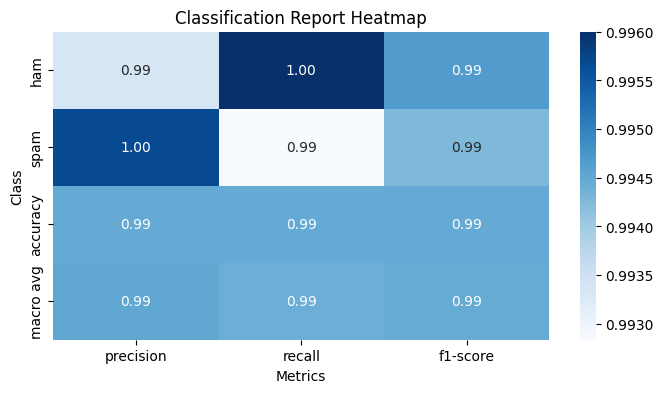

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate the classification report
report = classification_report(y_test, y_test_pred, target_names=['ham', 'spam'], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot the classification report using a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Class')
plt.show()


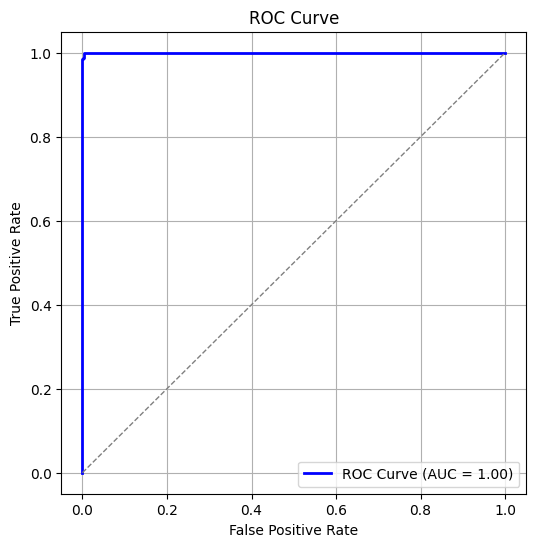

In [ ]:
# Convert categorical labels to binary integers
y_test_binary = y_test.map({'ham': 0, 'spam': 1})

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
